In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import utils_ss as ut
import os
import m_models as mm
from tqdm import tqdm_notebook as tqdm

import pylab

/Users/xtonev/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
def set_plt_params():
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 8
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.fontsize'] = 26
    plt.rcParams['axes.titlesize']=20
    plt.rcParams['axes.labelsize']=26
    plt.rcParams['font.size'] = 26

In [4]:
labels_for_plot = {
                    'cross': "$\mathsf{E}_{\mathfrak{D}_m}RS(m)$",
                    'apvc': "$\mathsf{E}_{\mathfrak{D}_m}\mathsf{D}[\hat{w}|\mathfrak{D}_m]$",
                    'acc': "$\mathsf{E}_{\mathfrak{D}_m}\mathsf{P}\{w \in A_{l}(\hat{w})\}$",
                    'alc': "$\mathsf{E}_{\mathfrak{D}_m}r_m$",
                    'maxu': "$\mathsf{E}_{\mathfrak{D}_m}\int_{w}u(\mathfrak{D}_m, w)p(w|\mathfrak{D}_m)dw$",
                    'kl': "$\mathsf{E}_{\mathfrak{D}_m}D_{KL}(p_1, p_2)$",
                    'bootstrap': "$\mathsf{E}_{\mathfrak{D}_m}$",
                    }

## Boston dataset

In [5]:
name = 'boston'
X, y = ut.DataLoader(name = name)
X, y = ut.preprocess(X, y)

print(X.shape)

methods = {'lagrange': lambda X, y: mm.lagrange(X, y),
            'ratio': lambda X, y: mm.likelihood_ratio(X, y),
            'wald': lambda X, y: mm.wald(X, y),
            'cross': lambda X, y: mm.cross_val(X, y, k_for_meaning=1000, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'apvc': lambda X, y: mm.APVC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'acc': lambda X, y: mm.ACC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'alc': lambda X, y: mm.ALC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'maxu': lambda X, y: mm.MAX_U(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'kl': lambda X, y: mm.KL_method(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'bootstrap': lambda X, y: mm.bootstrap(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'logistic': lambda X, y: mm.LogisticRegressionMethod(X, y),
          }
'''
answers = {}
for key in methods.keys():
    print('Calculating ' + key)
    answers[key] = methods[key](X, y)

print('--------------------')
for key in answers.keys():
    print( ('%-10s%s%d')%(key, ' = ', answers[key]['m*']))
    '''

(506, 12)


"\nanswers = {}\nfor key in methods.keys():\n    print('Calculating ' + key)\n    answers[key] = methods[key](X, y)\n\nprint('--------------------')\nfor key in answers.keys():\n    print( ('%-10s%s%d')%(key, ' = ', answers[key]['m*']))\n    "

In [7]:
'''
r = 5
for key in labels_for_plot.keys():
    plt.plot(answers[key]['m'][r:], answers[key]['E'][r:])

    plt.xlabel("$m$")
    plt.ylabel(labels_for_plot[key])
    plt.grid()
    plt.savefig('graphic/FullDataset/' + key + '.pdf')
    plt.show()
    '''

'\nr = 5\nfor key in labels_for_plot.keys():\n    plt.plot(answers[key][\'m\'][r:], answers[key][\'E\'][r:])\n\n    plt.xlabel("$m$")\n    plt.ylabel(labels_for_plot[key])\n    plt.grid()\n    plt.savefig(\'graphic/FullDataset/\' + key + \'.pdf\')\n    plt.show()\n    '

### Observation of model weights

In [8]:
boston_df = pd.DataFrame(np.hstack((X, y.reshape(1,-1).T)))

In [9]:
len(boston_df)

506

In [42]:
def test_linear_model_weights(data, init_size, step, num_of_tests=1):        
    weights = [[]]
    
    train_data = []
    chosen_data = []
    for i in range(num_of_tests):
        train_data.append(data.sample(n=init_size, random_state=i))
        chosen_data.append(np.array(train_data[i].index))
    
        model = ut.LinearModel(train_data[i].iloc[:,-1], train_data[i].iloc[:,:-1])
        weights[0].append(model.fit().values)
    
    x = [0]
    for k, j in enumerate(range(init_size, len(data)+1, step)):
        weights.append([])
        
        sample_size = min(step, len(data)-j)
        for i in range(num_of_tests):
            add_data = data.loc[~data.index.isin(chosen_data[i])].sample(n=sample_size, random_state=i)
            chosen_data[i] = np.concatenate((chosen_data[i], add_data.index))
            train_data[i] = pd.concat((train_data[i], add_data))

            model = ut.LinearModel(train_data[i].iloc[:,-1], train_data[i].iloc[:,:-1])
            weights[k+1].append(model.fit().values)
            
        x.append(j)
     
    x = np.array(x)
    x = x / max(x) * 100
    return np.array(weights), x

In [11]:
boston_weights, x = test_linear_model_weights(boston_df, 0, 5, num_of_tests=50)

In [12]:
set_plt_params()
plt.rcParams['figure.figsize'] = (10.0, 6.0)

/Users/xtonev/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


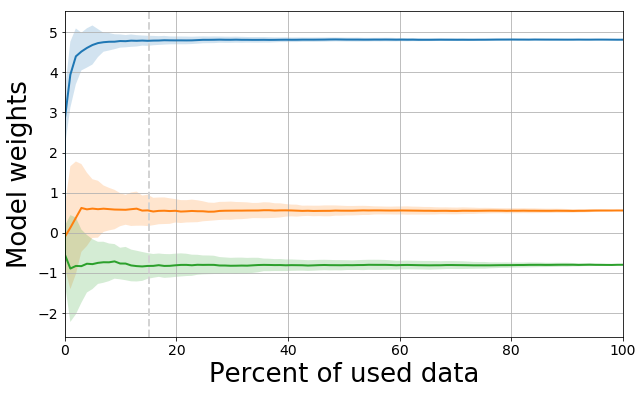

In [13]:
plt.axvline(x=15, linestyle='dashed', color='lightgrey')

chosen_weights = [0,7,11]
    
mean = np.mean(boston_weights, axis=1)
std = np.std(boston_weights, axis=1)

for ind in chosen_weights:
    mean_ind = mean[:,[ind]].reshape(-1)
    std_ind = std[:,[ind]].reshape(-1)
    
    plt.plot(x, mean_ind)
    plt.fill_between(x, mean_ind - std_ind, mean_ind + std_ind, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model weights")
plt.grid()
plt.show()

### Observation of model error

In [57]:
def test_linear_model_error(data, init_size, step, test_data, num_of_tests=1):    
    error = [[]]
    
    train_data = []
    chosen_data = []
    for i in range(num_of_tests):
        train_data.append(data.sample(n=init_size, random_state=i))
        chosen_data.append(np.array(train_data[i].index))
    
        model = ut.LinearModel(train_data[i].iloc[:,-1], train_data[i].iloc[:,:-1])
        w = model.fit()
        error[0].append(((np.dot(w.values.reshape(1,-1), test_data.iloc[:,:-1].T) - test_data.iloc[:,-1].values)**2).sum())
    
    x = [0]
    for k, j in enumerate(range(init_size, len(data)+1, step)):
        error.append([])
        
        sample_size = min(step, len(data)-j)
        for i in range(num_of_tests):
            add_data = data.loc[~data.index.isin(chosen_data[i])].sample(n=sample_size, random_state=i)
            chosen_data[i] = np.concatenate((chosen_data[i], add_data.index))
            train_data[i] = pd.concat((train_data[i], add_data))

            model = ut.LinearModel(train_data[i].iloc[:,-1], train_data[i].iloc[:,:-1])
            w = model.fit()
            error[k+1].append(((np.dot(w.values.reshape(1,-1), test_data.iloc[:,:-1].T) - test_data.iloc[:,-1].values)**2).sum())
            
        x.append(j)
     
    x = np.array(x)
    x = x / max(x) * 100
    return np.array(error), x

In [15]:
boston_train = boston_df.sample(400, random_state=1)
boston_test = boston_df.loc[~boston_df.index.isin(boston_train.index)]

In [16]:
boston_error, x = test_linear_model_error(boston_train, 0, 5, boston_test, num_of_tests=50)

In [17]:
set_plt_params()
plt.rcParams['figure.figsize'] = (10.0, 6.0)

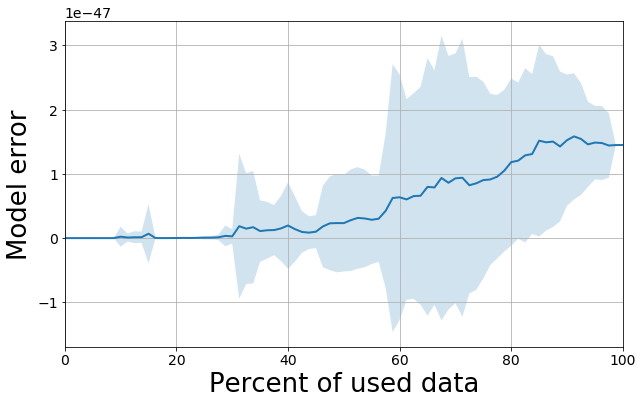

In [18]:
mean = np.mean(np.exp(-boston_error), axis=1)
std = np.std(np.exp(-boston_error), axis=1)

plt.plot(x, mean)
plt.fill_between(x, mean - std, mean + std, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model error")
plt.grid()
plt.show()

### 3D model error with num of features

In [28]:
import matplotlib
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d    

%matplotlib notebook

In [106]:
def test_linear_model_error_features(data, train_data, test_data, init_size, step, num_of_tests=1):  
    model = ut.LinearModel(data.iloc[:,-1], data.iloc[:,:-1])
    w = model.fit()
    features_order = np.absolute(w).argsort()[::-1].values
    
    answer = [len(features_order)]
    
    error = [[]]
    
    train_data_sampled = []
    chosen_data = []
    for l in range(1, len(features_order)+1):
        train_data_sampled.append([])
        chosen_data.append([])
        error[0].append([])
        
        for i in range(num_of_tests):
            train_data_sampled[l-1].append(train_data.iloc[:,list(features_order[:l])+answer]
                                           .sample(n=init_size, random_state=i))
            chosen_data[l-1].append(np.array(train_data_sampled[l-1][i].index))

            model = ut.LinearModel(train_data_sampled[l-1][i].iloc[:,-1], train_data_sampled[l-1][i].iloc[:,:-1])
            w = model.fit()
            error[0][l-1].append(((np.dot(w.values.reshape(1,-1), test_data.iloc[:,features_order[:l]].T) - 
                                   test_data.iloc[:,-1].values)**2).sum())
    
    size = [0]
    for k, j in enumerate(range(init_size+step, len(train_data)+1, step)):
        error.append([])
        
        sample_size = min(step, len(train_data)-j)
        for l in range(1, len(features_order)+1):
            error[k+1].append([])
            
            for i in range(num_of_tests):
                add_data = (train_data
                            .iloc[:,list(features_order[:l])+answer]
                            .loc[~train_data.iloc[:,list(features_order[:l])+answer].index.isin(chosen_data[l-1][i])]
                            .sample(n=sample_size, random_state=i)
                           )
                train_data_sampled[l-1][i] = pd.concat((train_data_sampled[l-1][i], add_data))
                chosen_data[l-1][i] = np.concatenate((chosen_data[l-1][i], add_data.index))

                model = ut.LinearModel(train_data_sampled[l-1][i].iloc[:,-1], train_data_sampled[l-1][i].iloc[:,:-1])
                w = model.fit()
                error[k+1][l-1].append(((np.dot(w.values.reshape(1,-1), test_data.iloc[:,features_order[:l]].T) - 
                                       test_data.iloc[:,-1].values)**2).sum())

        size.append(j)
     
    features = list(range(len(features_order)))
    return np.array(error), features, size

In [101]:
'''x = boston_df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_boston_df = pd.DataFrame(x_scaled)
scaled_boston_df.iloc[:,0] = 1
scaled_boston_df.iloc[:,12] = boston_df.iloc[:,12]
'''

'x = boston_df.values\nmin_max_scaler = preprocessing.MinMaxScaler()\nx_scaled = min_max_scaler.fit_transform(x)\nscaled_boston_df = pd.DataFrame(x_scaled)\nscaled_boston_df.iloc[:,0] = 1\nscaled_boston_df.iloc[:,12] = boston_df.iloc[:,12]\n'

In [102]:
boston_error, features, size = test_linear_model_error_features(boston_df, boston_train, boston_test, 
                                                                0, 5, num_of_tests=5)

In [103]:
matplotlib.style.use('default')

<IPython.core.display.Javascript object>


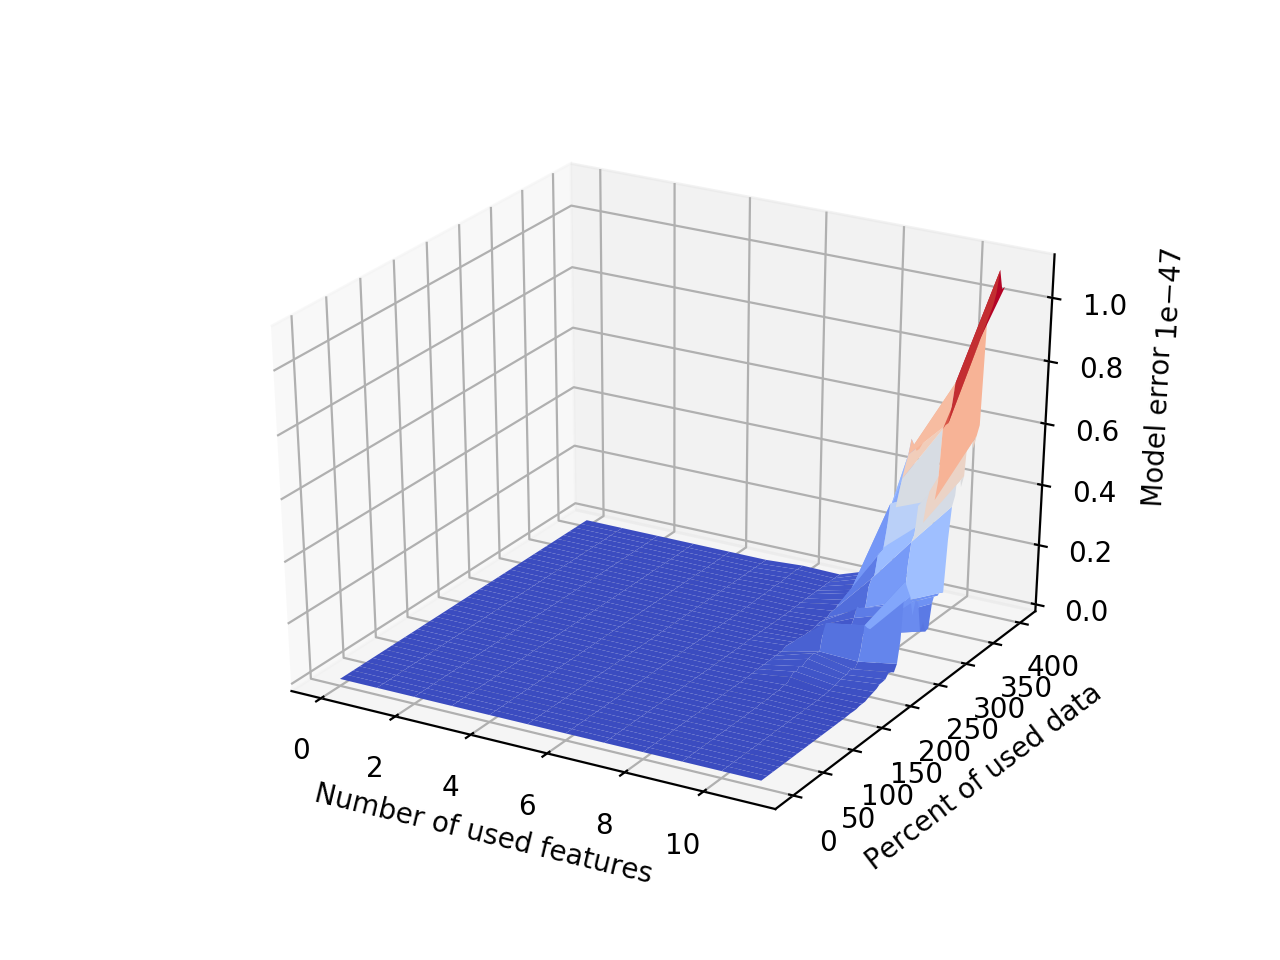

In [104]:
mean = np.exp(-np.mean(boston_error, axis=2))
std = np.std(boston_error, axis=2)

xv, yv = np.meshgrid(features, size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.plot_wireframe(xv, yv, mean)
ax.plot_surface(xv, yv, mean, cmap=cm.coolwarm, linewidth=0)

plt.xlabel("Number of used features")
plt.ylabel("Percent of used data")
ax.set_zlabel("Model error")
plt.show()

## Servo dataset

In [157]:
name = 'servo'
X, y = ut.DataLoader(name = name)
X, y = ut.preprocess(X, y)

print(X.shape)

(167, 5)


### Observation of model weights

In [30]:
servo_df = pd.DataFrame(np.hstack((X, y.reshape(1,-1).T)))

In [33]:
servo_df.shape

(167, 6)

In [43]:
servo_weights, x = test_linear_model_weights(servo_df, 0, 5, num_of_tests=50)

In [ ]:
set_plt_params()
plt.rcParams['figure.figsize'] = (10.0, 6.0)

<IPython.core.display.Javascript object>


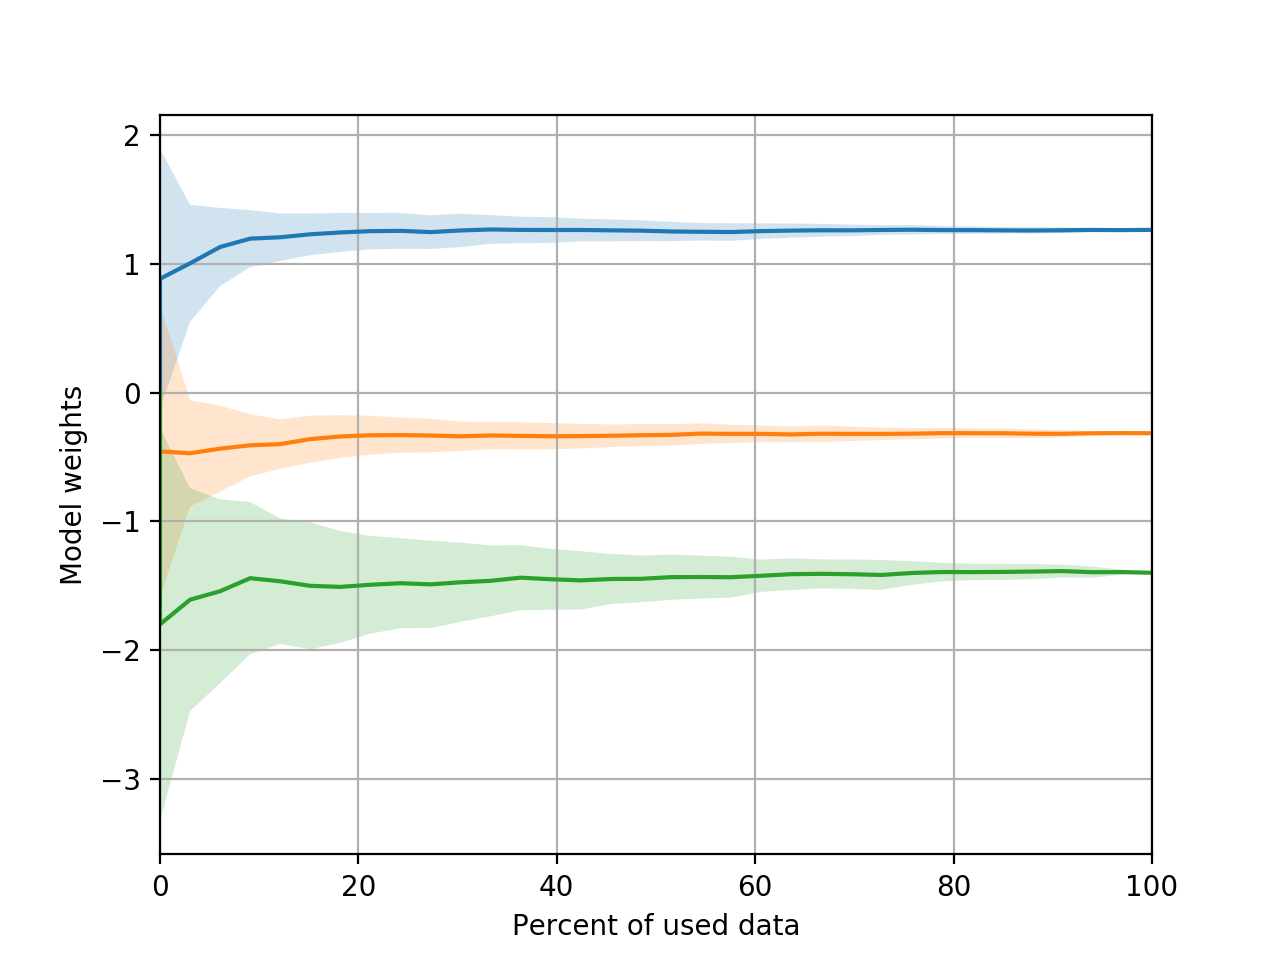

In [56]:
chosen_weights = [0,1,3]
    
mean = np.mean(servo_weights, axis=1)
std = np.std(servo_weights, axis=1)

for ind in chosen_weights:
    mean_ind = mean[:,[ind]].reshape(-1)
    std_ind = std[:,[ind]].reshape(-1)
    
    plt.plot(x, mean_ind)
    plt.fill_between(x, mean_ind - std_ind, mean_ind + std_ind, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model weights")
plt.grid()
plt.show()

### Observation of model error

In [58]:
servo_train = servo_df.sample(130, random_state=1)
servo_test = servo_df.loc[~servo_df.index.isin(servo_train.index)]

In [63]:
servo_error, x = test_linear_model_error(servo_train, 0, 5, servo_test, num_of_tests=100)

In [64]:
set_plt_params()
plt.rcParams['figure.figsize'] = (10.0, 6.0)

<IPython.core.display.Javascript object>


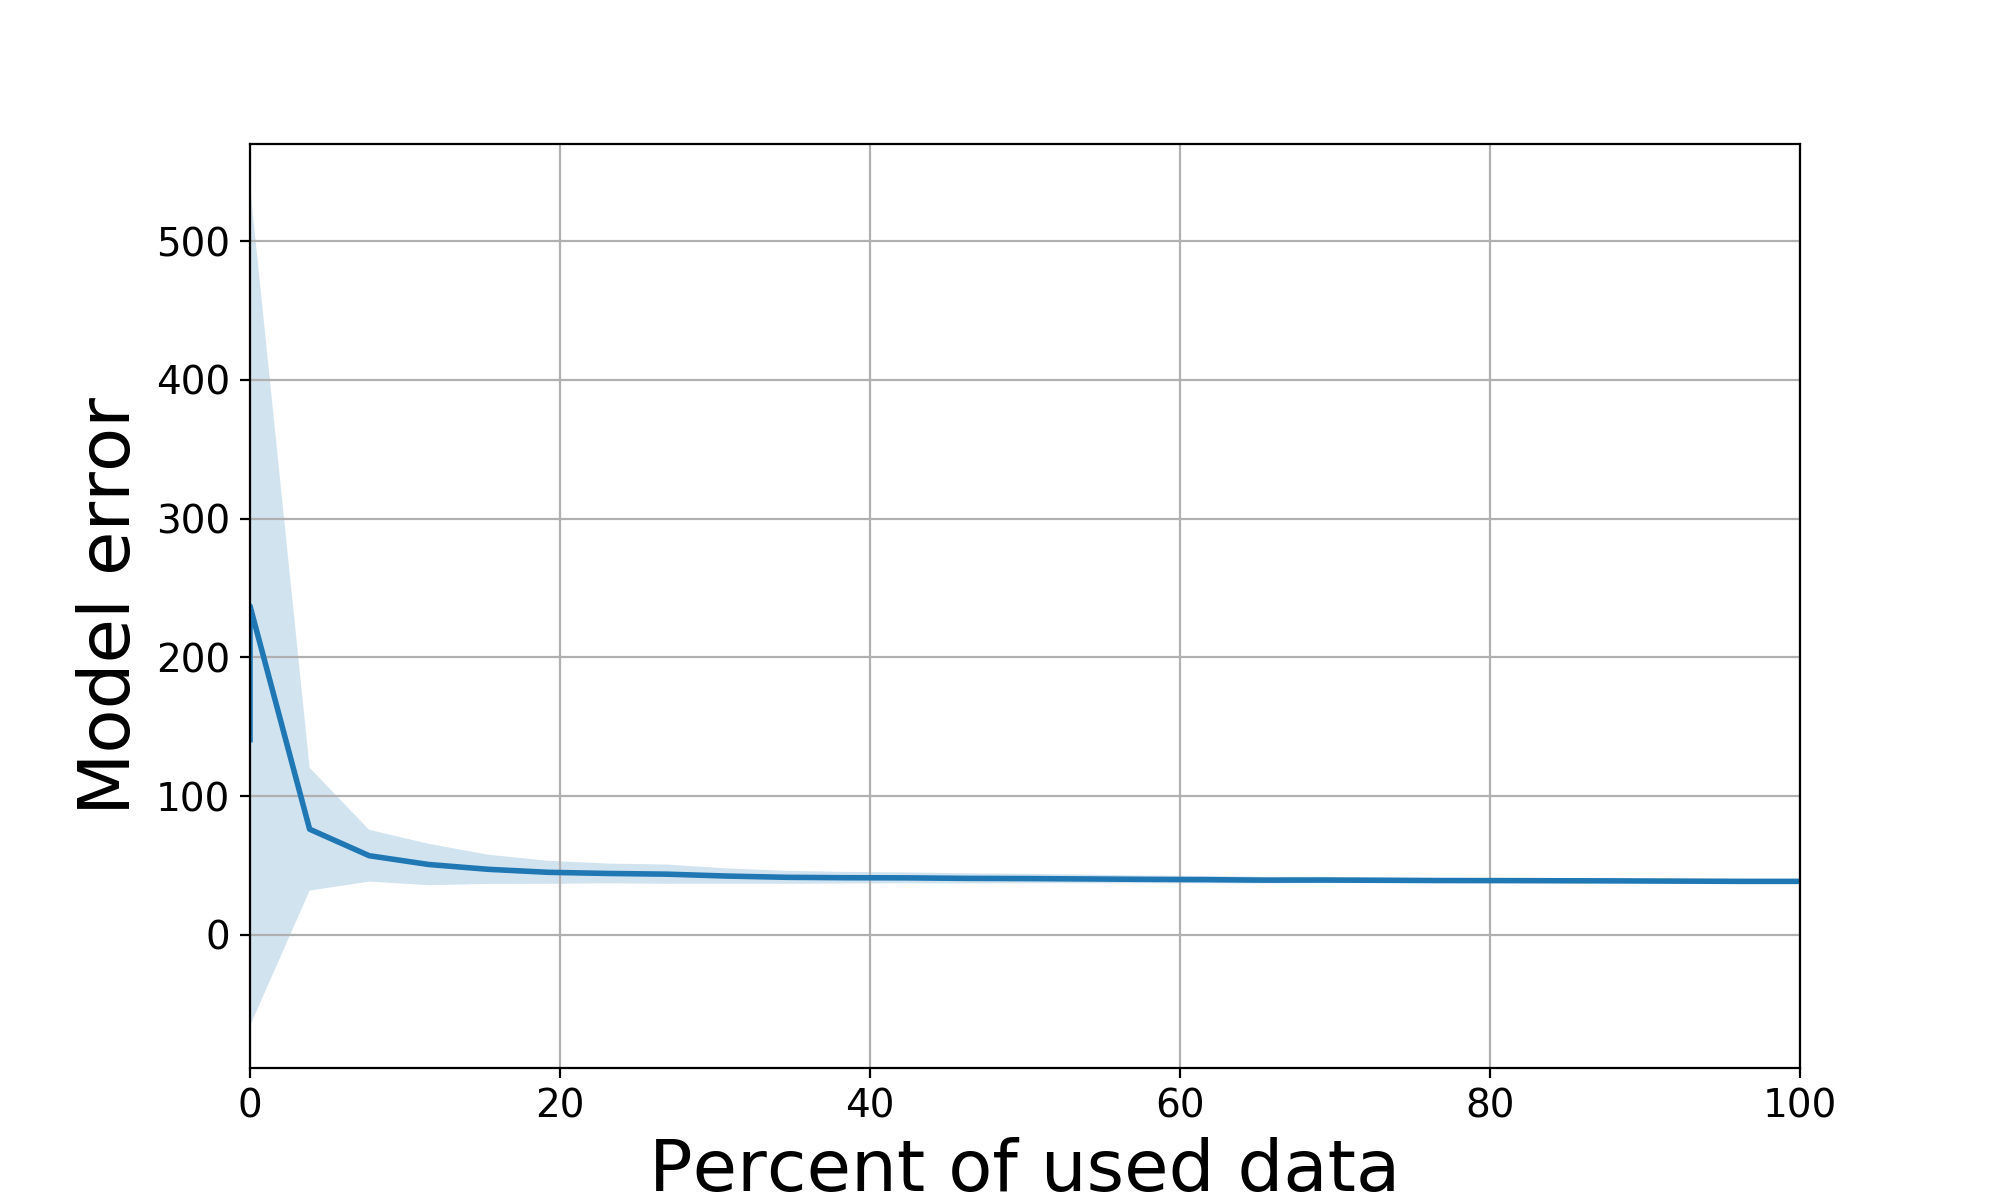

In [88]:
mean = np.mean(servo_error, axis=1)
std = np.std(servo_error, axis=1)

plt.plot(x, mean)
plt.fill_between(x, mean - std, mean + std, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model error")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


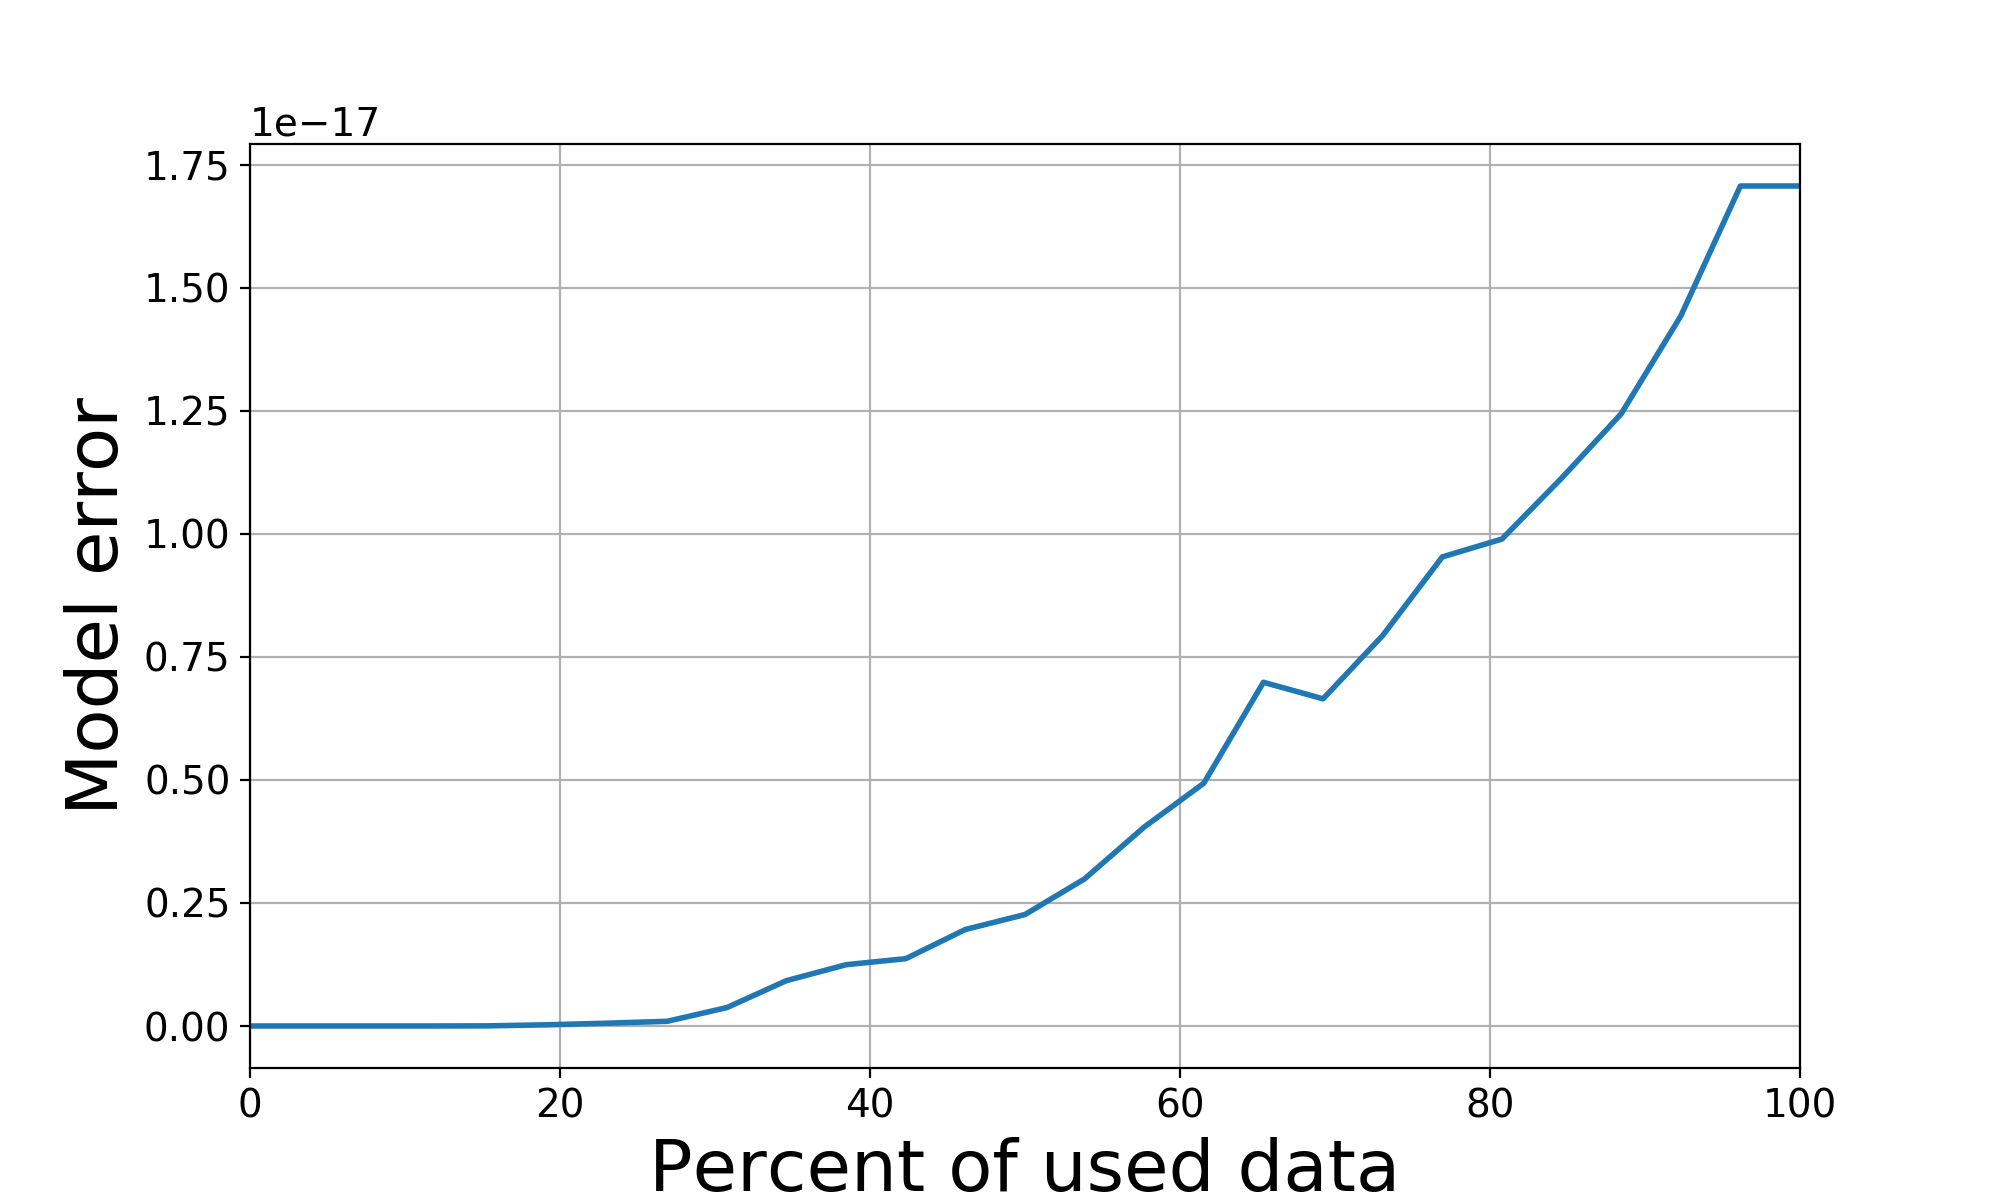

In [96]:
exp_mean = np.exp(-mean)

plt.plot(x, exp_mean)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model error")
plt.grid()
plt.show()

### 3D model error with num of features

In [23]:
'''x = boston_df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_boston_df = pd.DataFrame(x_scaled)
scaled_boston_df.iloc[:,0] = 1
scaled_boston_df.iloc[:,12] = boston_df.iloc[:,12]
'''

'x = boston_df.values\nmin_max_scaler = preprocessing.MinMaxScaler()\nx_scaled = min_max_scaler.fit_transform(x)\nscaled_boston_df = pd.DataFrame(x_scaled)\nscaled_boston_df.iloc[:,0] = 1\nscaled_boston_df.iloc[:,12] = boston_df.iloc[:,12]\n'

In [107]:
servo_error, features, size = test_linear_model_error_features(servo_df, servo_train, servo_test, 
                                                               0, 5, num_of_tests=5)

In [108]:
matplotlib.style.use('default')

<IPython.core.display.Javascript object>


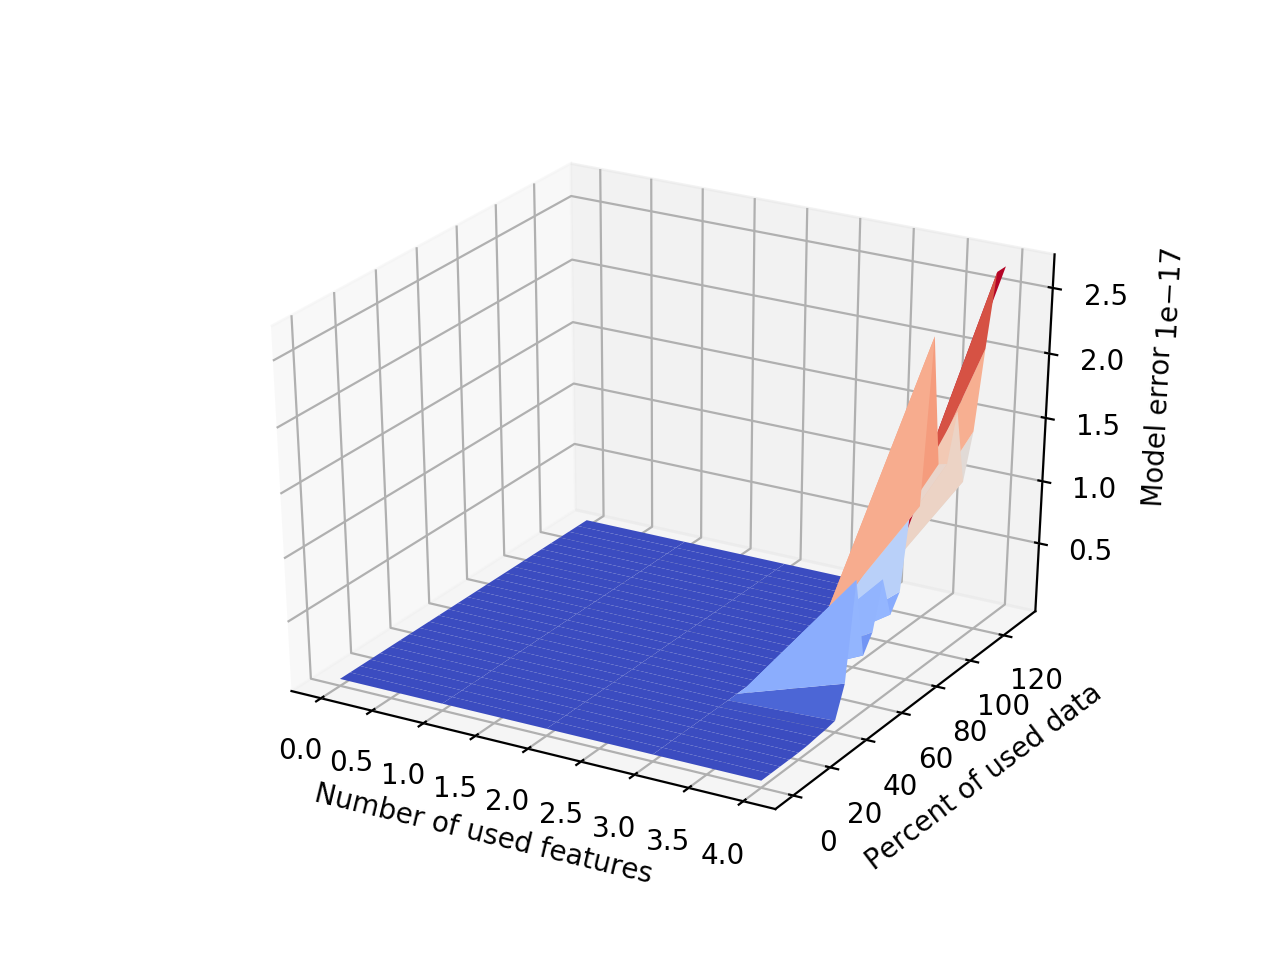

In [114]:
mean = np.exp(-np.mean(servo_error, axis=2))
std = np.std(servo_error, axis=2)

#mean = np.mean(servo_error, axis=2)

xv, yv = np.meshgrid(features, size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.plot_wireframe(xv, yv, mean)
ax.plot_surface(xv, yv, mean, cmap=cm.coolwarm, linewidth=0)

plt.xlabel("Number of used features")
plt.ylabel("Percent of used data")
ax.set_zlabel("Model error")
plt.show()

## Sberbank housing dataset

In [164]:
sberbank_train = pd.read_csv('datasets/housing_train.csv', index_col=0).fillna(0).select_dtypes(exclude=['object'])
#sberbank_test = pd.read_csv('datasets/housing_test.csv', index_col=0).fillna(0).select_dtypes(exclude=['object'])
#sberbank_df = pd.concat((sberbank_train, sberbank_test))

X, y = sberbank_train.iloc[:,:-1].values, sberbank_train.iloc[:,-1].values
X, y = ut.preprocess(X, y)

print(X.shape)

(30471, 34)


### Observation of model weights

In [165]:
sberbank_df = pd.DataFrame(np.hstack((X, y.reshape(1,-1).T)))

In [166]:
sberbank_df.shape

(30471, 35)

In [168]:
sberbank_weights, x = test_linear_model_weights(sberbank_df, 0, 5, num_of_tests=5)

In [169]:
set_plt_params()
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [175]:
np.mean(sberbank_weights, axis=1)[-1]

array([ 1.87396395,  0.31321341,  0.09407195,  0.14932705, -0.03368983,
        0.37825929, -0.08966509, -0.16055099,  0.22291125,  0.04233104,
        0.69008202, -0.92176518,  0.08731096, -0.06959437, -0.05054307,
        0.00709808,  0.03883828, -0.09334556, -0.04592534,  0.07629686,
        0.04975141, -0.0622933 ,  0.51580414, -0.10255686, -0.37804179,
        0.17177875, -0.82153397,  0.02523486,  0.0948055 , -0.07815786,
       -0.13580623,  0.19690917,  0.30139484, -0.08584176])

<IPython.core.display.Javascript object>


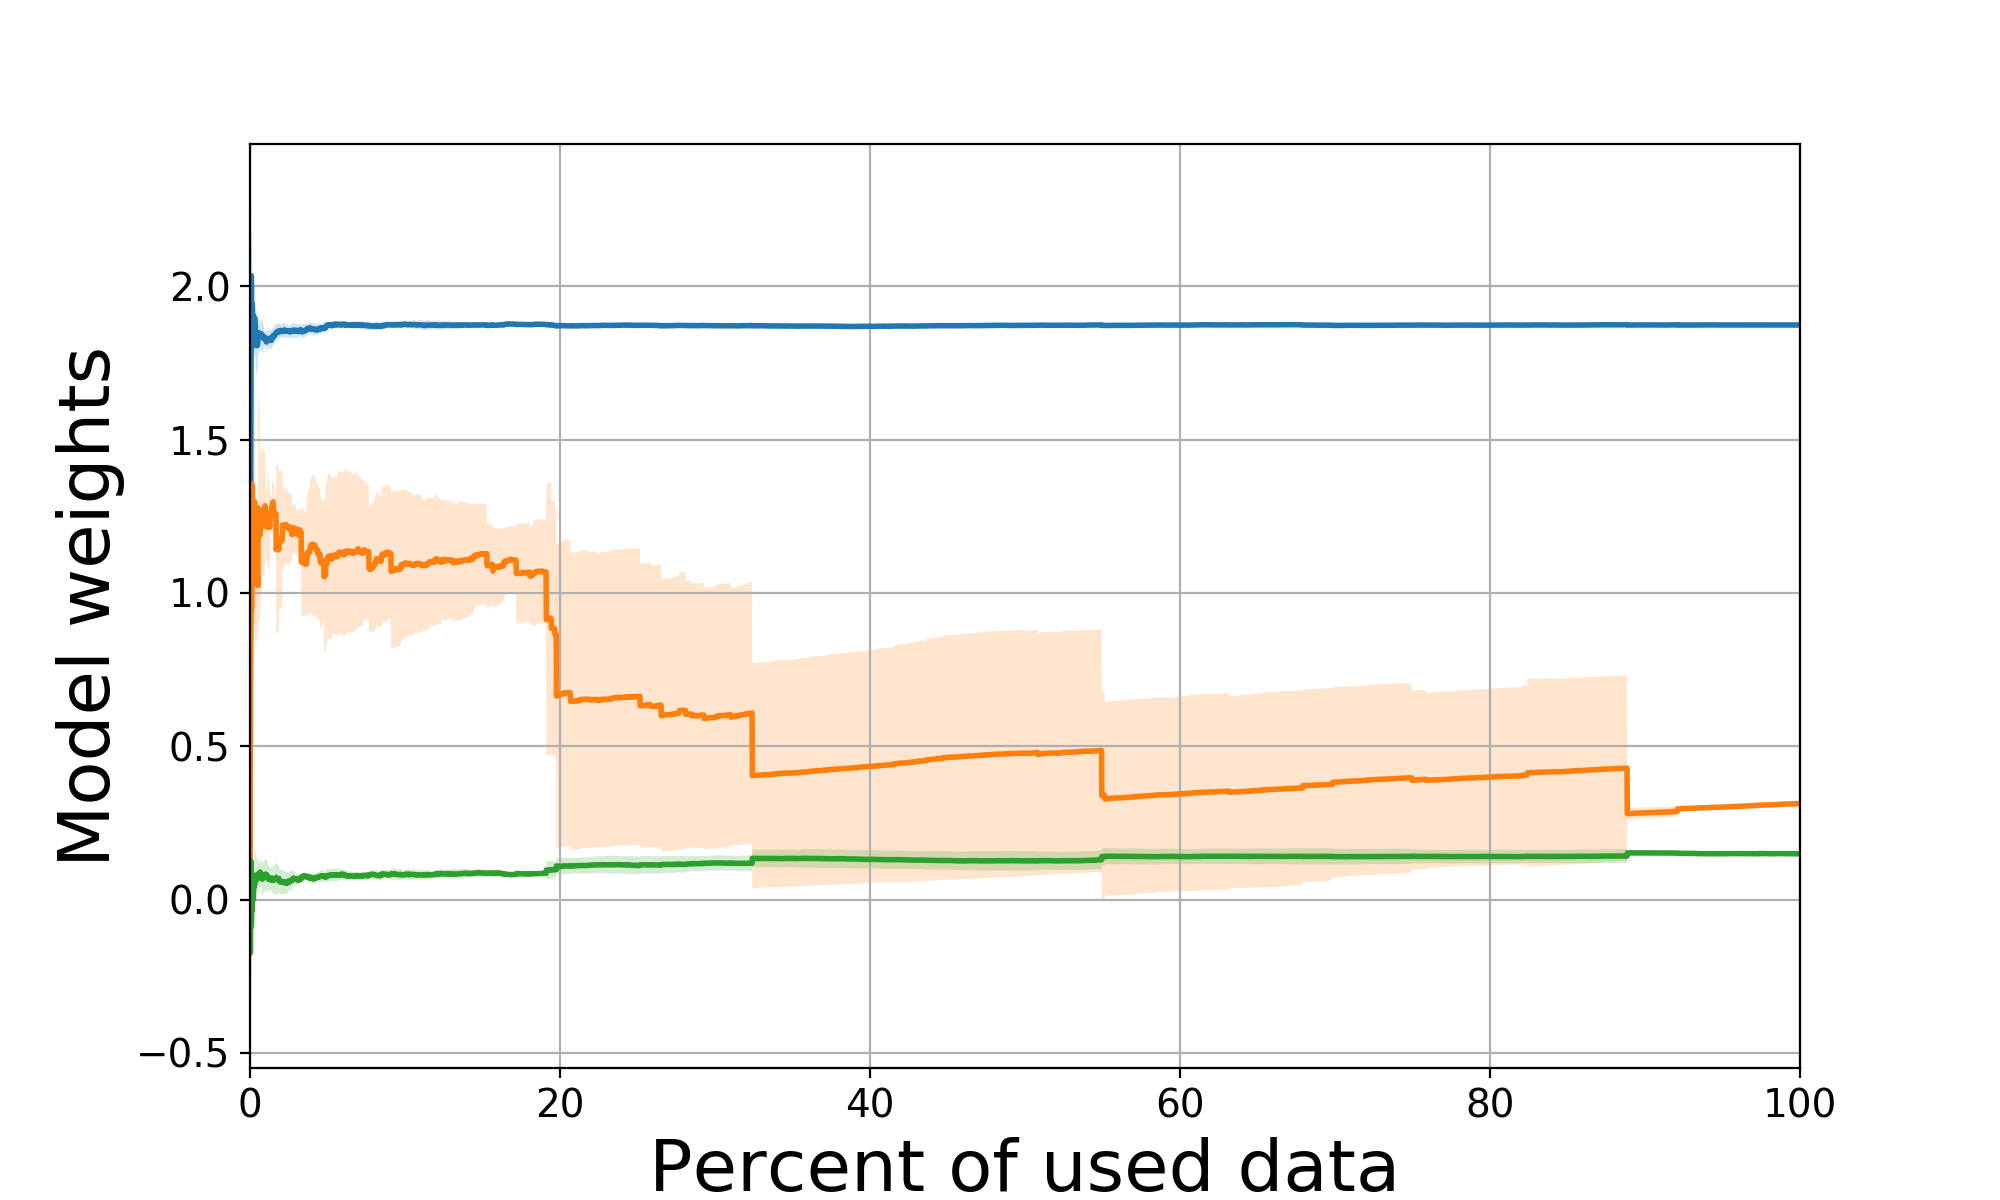

/Users/xtonev/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [170]:
chosen_weights = [0,1,3]
    
mean = np.mean(sberbank_weights, axis=1)
std = np.std(sberbank_weights, axis=1)

for ind in chosen_weights:
    mean_ind = mean[:,[ind]].reshape(-1)
    std_ind = std[:,[ind]].reshape(-1)
    
    plt.plot(x, mean_ind)
    plt.fill_between(x, mean_ind - std_ind, mean_ind + std_ind, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model weights")
plt.grid()
plt.show()

### Observation of model error

In [58]:
servo_train = servo_df.sample(130, random_state=1)
servo_test = servo_df.loc[~servo_df.index.isin(servo_train.index)]

In [63]:
servo_error, x = test_linear_model_error(servo_train, 0, 5, servo_test, num_of_tests=100)

In [64]:
set_plt_params()
plt.rcParams['figure.figsize'] = (10.0, 6.0)

<IPython.core.display.Javascript object>


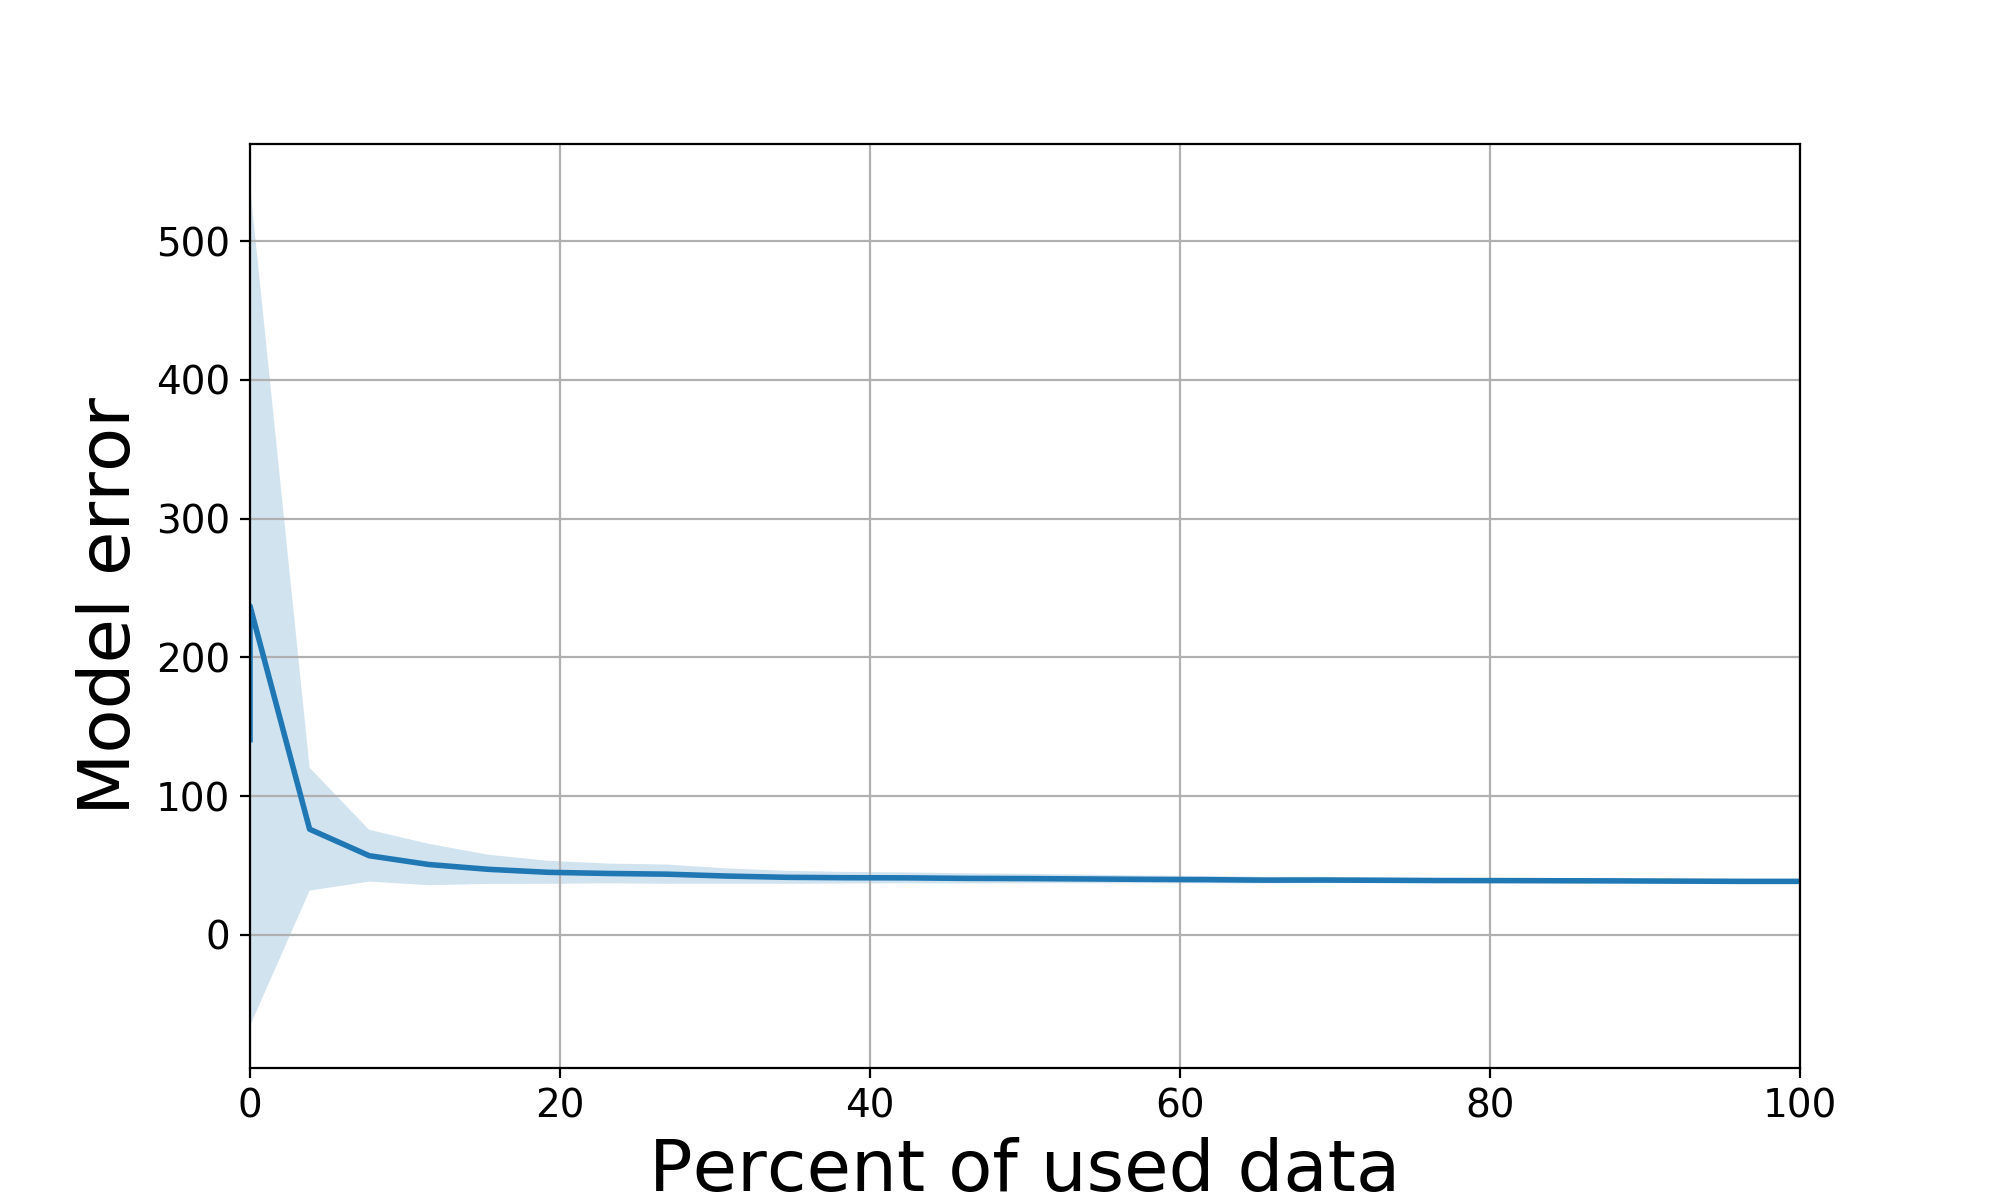

In [88]:
mean = np.mean(servo_error, axis=1)
std = np.std(servo_error, axis=1)

plt.plot(x, mean)
plt.fill_between(x, mean - std, mean + std, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model error")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


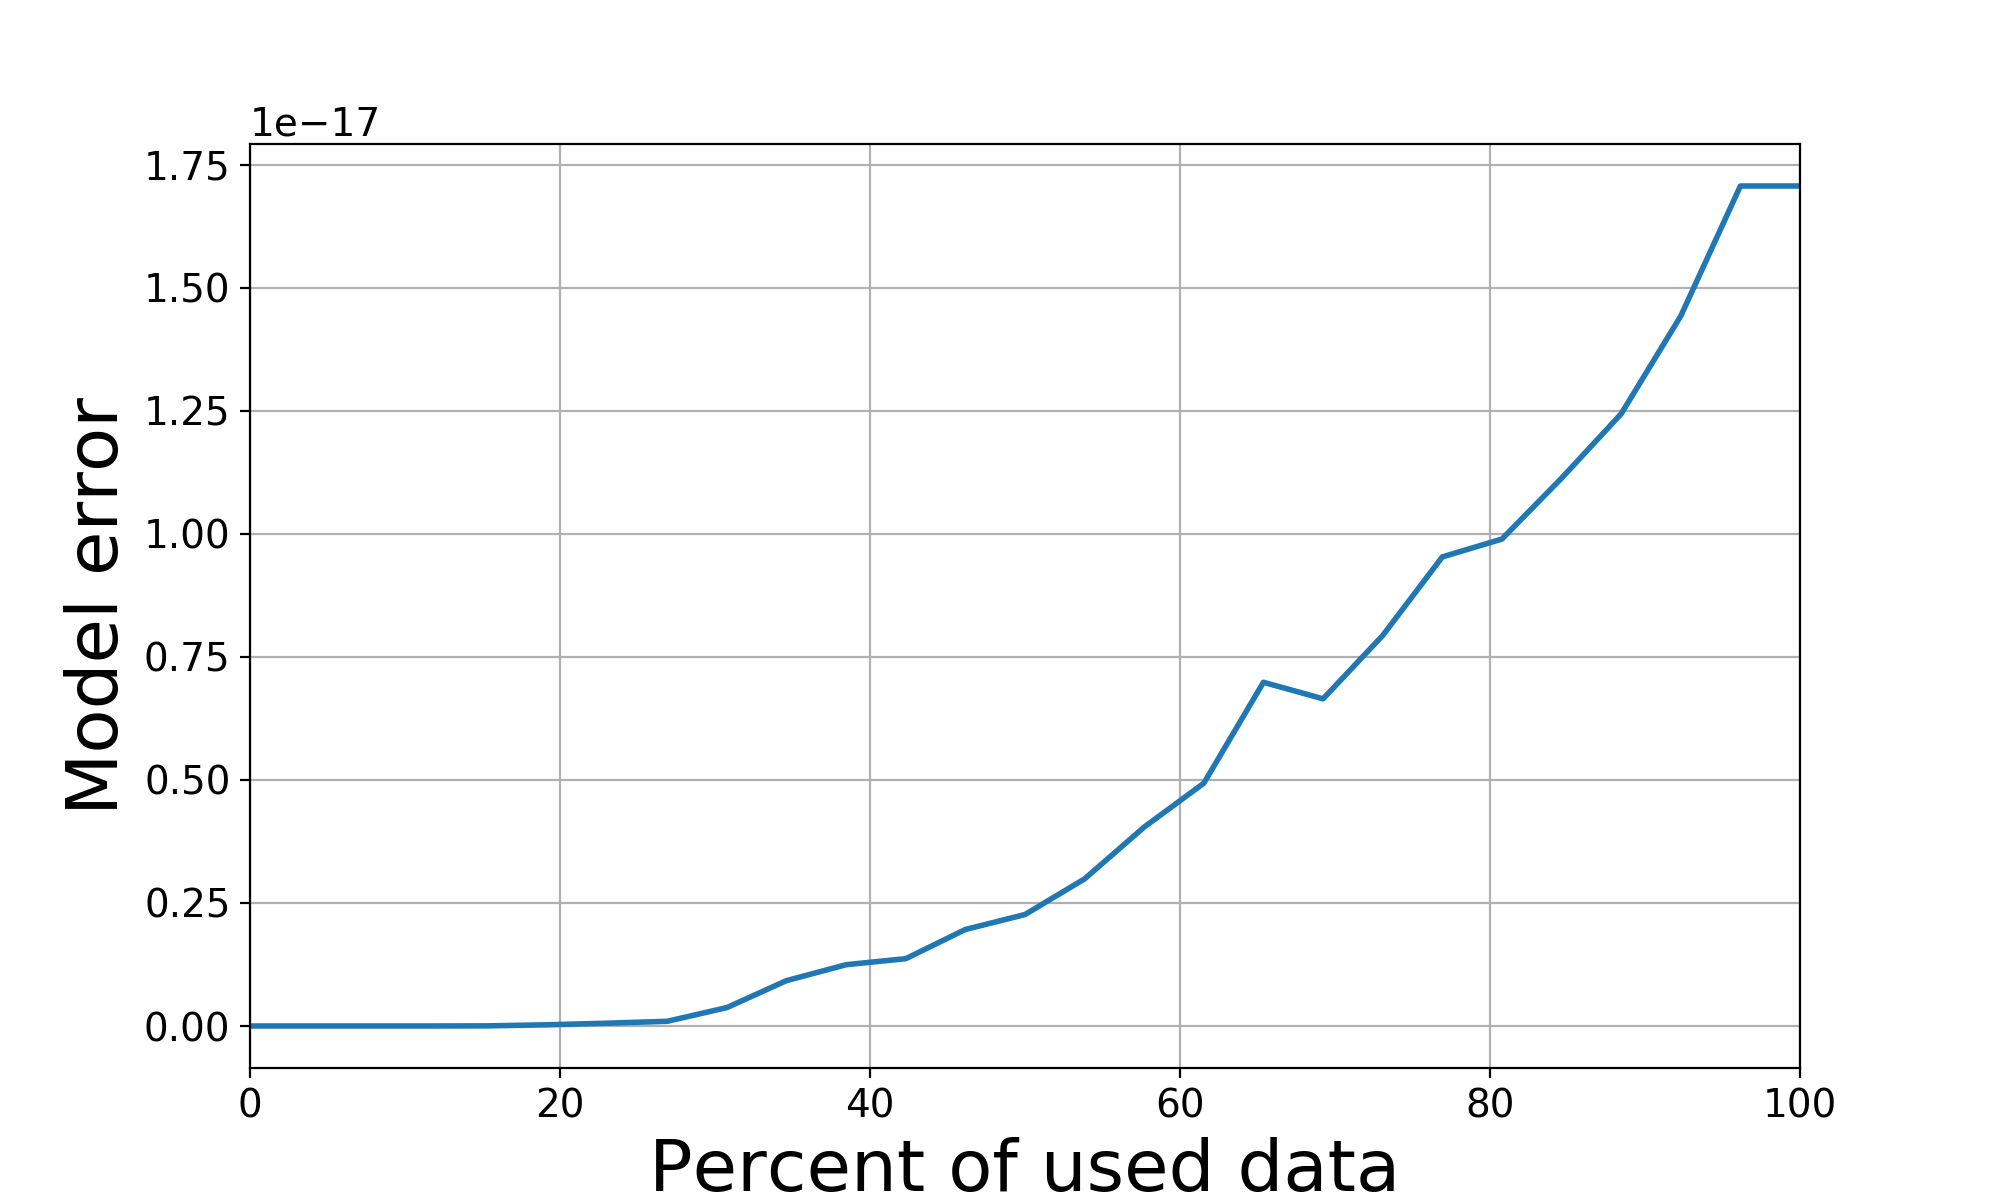

In [96]:
exp_mean = np.exp(-mean)

plt.plot(x, exp_mean)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model error")
plt.grid()
plt.show()

### 3D model error with num of features

In [23]:
'''x = boston_df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_boston_df = pd.DataFrame(x_scaled)
scaled_boston_df.iloc[:,0] = 1
scaled_boston_df.iloc[:,12] = boston_df.iloc[:,12]
'''

'x = boston_df.values\nmin_max_scaler = preprocessing.MinMaxScaler()\nx_scaled = min_max_scaler.fit_transform(x)\nscaled_boston_df = pd.DataFrame(x_scaled)\nscaled_boston_df.iloc[:,0] = 1\nscaled_boston_df.iloc[:,12] = boston_df.iloc[:,12]\n'

In [107]:
servo_error, features, size = test_linear_model_error_features(servo_df, servo_train, servo_test, 
                                                               0, 5, num_of_tests=5)

In [108]:
matplotlib.style.use('default')

<IPython.core.display.Javascript object>


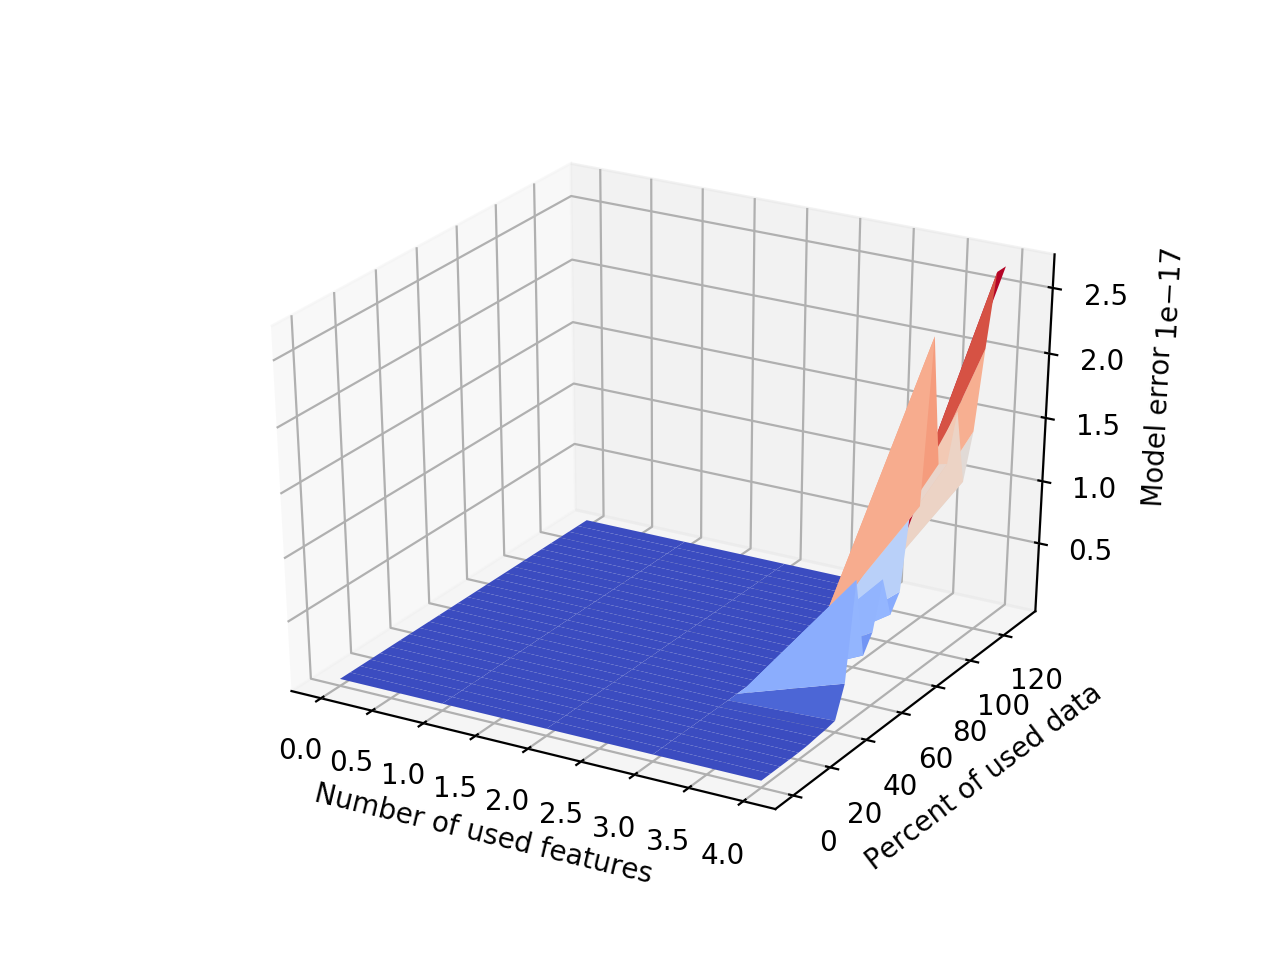

In [114]:
mean = np.exp(-np.mean(servo_error, axis=2))
std = np.std(servo_error, axis=2)

#mean = np.mean(servo_error, axis=2)

xv, yv = np.meshgrid(features, size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.plot_wireframe(xv, yv, mean)
ax.plot_surface(xv, yv, mean, cmap=cm.coolwarm, linewidth=0)

plt.xlabel("Number of used features")
plt.ylabel("Percent of used data")
ax.set_zlabel("Model error")
plt.show()